# 1- وارد کردن دیتاست

In [9]:
import pandas as pd
data = pd.read_csv("SMSSpamCollection.txt", sep= '\t', header=None, names=["Target", "Email"])


data.columns
data.shape

(5572, 2)

# 2- بررسی داده

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Email   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [13]:
data.groupby('Target').describe()

Email                                                               
       count unique                                                top freq
Target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

# 3- پیش پردازش داده

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, naive_bayes, metrics


In [17]:
#pre processing steps like lower case, stemming and lemmatization
data['Email'] =  data['Email'].apply(lambda x:  " ".join(x.lower() for x in x.split()))
# stopword filtering
stop = stopwords.words('english')
data['Email'] =  data['Email'].apply(lambda x: " ".join (x for x in x.split() if x not in stop))
#stemming
st = PorterStemmer()
data['Email'] =  data['Email'].apply(lambda x: " ".join ([st.stem(word) for word in x.split()]))
#lemmatize
data['Email'] =  data['Email'].apply(lambda x: " ".join ([Word(word).lemmatize() for word in x.split()]))
data.head()

,Target,Email
0,ham,"go jurong point, crazy.. avail bugi n great wo..."
1,ham,ok lar... joke wif u oni...
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor... u c alreadi say...
4,ham,"nah think goe usf, live around though"


# 4- تولید نمونه برای پیش گیری از طبقه بندی نامتقارن

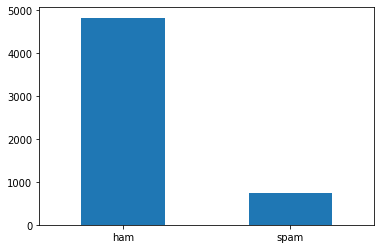

In [18]:
result=data['Target'].value_counts()
result.plot(kind='bar', rot=0);

In [19]:
# sampling
spam = data[data['Target'] == 'spam'].sample(n=700)
ham = data[data['Target'] == 'ham'].sample(n=700)


In [21]:
Email_sample = pd.concat([spam, ham],axis=0)
Email_sample.head()

,Target,Email
3556,spam,next month get upto 50% call 4 ur standard net...
4629,spam,today voda number end 7634 select receiv £350 ...
4272,spam,natalja (25/f) invit friend. repli yes-440 no-...
4154,spam,urgent!! 4* costa del sol holiday £5000 await ...
3642,spam,"stop club tone repli ""stop mix"" see my-tone.co..."


# 5- ساخت ابر واژگان

In [22]:
from wordcloud import WordCloud 
from wordcloud import STOPWORDS


In [23]:
spam =  Email_sample[Email_sample['Target'] == 'spam']
ham =  Email_sample[Email_sample['Target'] == 'ham']

In [24]:
spam_str = spam.Email.str.cat()
ham_str = ham.Email.str.cat()

In [25]:
wordcloud_spam =  WordCloud(background_color='white').generate (spam_str)


Text(0.5, 1.0, 'why detected as spam')

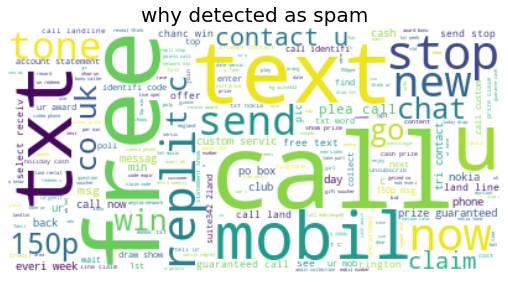

In [26]:
# Plot
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_spam,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('why detected as spam',fontsize=20)

Text(0.5, 1.0, 'why detected as ham')

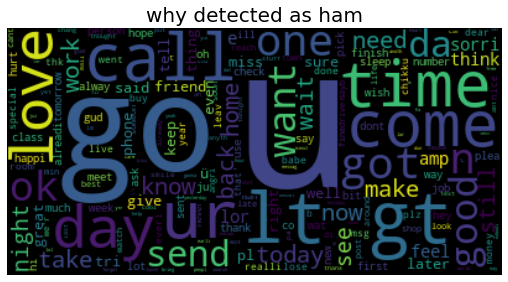

In [27]:
wordcloud_ham =  WordCloud(background_color='black').generate (ham_str)
# Plot
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_ham,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('why detected as ham',fontsize=20)

# 6- تقسیم بندی دیتاست در دو مجموعه آموزش و تست

In [28]:
#Splitting data into train and validation
x_Train, x_Test, y_Train, y_Test = train_test_split(Email_Data['Email'], Email_Data['Target'], test_size = 0.2, random_state = 0)



# 7- تبدیل متن به بردار ویژگی

In [29]:
# TFIDF feature generation for a maximum of 5000 features
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_Train)
valid_y = encoder.fit_transform(y_Test)

In [30]:
tfidf_vect =  TfidfVectorizer(analyzer='word',  token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Email_Data['Email'])
xtrain_tfidf =  tfidf_vect.transform(x_Train)
xvalid_tfidf =  tfidf_vect.transform(x_Test)

In [31]:
xtrain_tfidf.data

array([0.17498273, 0.26009221, 0.24689711, ..., 0.20368464, 0.35585231,
       0.2690574 ])

# 8- ساخت مدل

In [32]:

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    return metrics.accuracy_score(predictions, valid_y)


# 9- ارزیابی مدل

In [33]:
# Naive Bayes trainig
accuracy = train_model(naive_bayes.MultinomialNB(alpha=0.2), xtrain_tfidf, train_y, xvalid_tfidf)
print ("Accuracy: ", accuracy)


Accuracy:  0.9874439461883409


In [34]:
# Linear Classifier on Word Level TF IDF Vectors
from sklearn import linear_model
accuracy =  train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf) 
print ("Accuracy: ", accuracy)


Accuracy:  0.9713004484304932
